# Uncertainty and Saving in Partial Equilibrium

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/DemARK/master?filepath=notebooks%2FUncertainty-and-the-Saving-Rate.ipynb)

Saving rates vary widely across countries, but there is no consensus about the main causes of those differences.

One commonly mentioned factor is differences across countries in the degree of uncertainty that individuals face, which should induce different amounts of precautionary saving.

Uncertainty might differ for "fundamental" reasons, having to do with, say, the volatility of demand for the goods and services supplied by the country, or might differ as a result of economic policies, such as the strucutre of the social insurance system.

A challenge in evaluating the importance of precautionary motives for cross-country saving differences has been a lack of consensus about what measures of uncertainty ought, in principle, to be the right ones to look at in any attempt to measure a relationship between uncertainty and saving.

This notebook uses [a standard model](https://econ.jhu.edu/people/ccarroll/papers/cstwMPC) <cite data-cite="6202365/7MR8GUVS"></cite> to construct a theoretical benchmark for the relationship of saving to two kinds of uncertainty: Permanent shocks and transitory shocks to income.  

Conclusions:
1. The model implies a close to linear relationship between the variance of either kind of shock (transitory or permanent) and the saving rate
2. The _slope_ of that relationship is much steeper for permanent than for transitory shocks
   * Over ranges of values calibrated to be representative of microeconomically plausible magnitudes

Thus, the quantitative theory of precautionary saving says that the principal determinant of precautionary saving should be the magnitude of permanent (or highly persistent) shocks to income.

(Because the result was obtained in a partial equilibrium model, the conclusion applies also to attempts to measure the magnitude of precautionary saving across groups of people who face different degrees of uncertainty within a country).

@authors: Derin Aksit, Tongli Zhang, Christopher Carroll

In [1]:
# Boring non-HARK setup stuff

Generator = True # This notebook can be used as a source for generating derivative notebooks
nb_name = 'Uncertainty-and-the-Saving-Rate'

# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"

from IPython import get_ipython # In case it was run from python instead of ipython
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')
    print('You appear to be running from a terminal')
    print('By default, figures will appear one by one')
    print('Close the visible figure in order to see the next one')

# Import the plot-figure library matplotlib

import matplotlib.pyplot as plt

# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.
from matplotlib import rc
plt.rc('font', family='serif')

# LaTeX is huge and takes forever to install on mybinder
# so if it is not installed then do not use it 
from distutils.spawn import find_executable
iflatexExists=False
if find_executable('latex'):
    iflatexExists=True
    
plt.rc('font', family='serif')
plt.rc('text', usetex=iflatexExists)

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

# The tools for navigating the filesystem
import sys
import os

sys.path.insert(0, os.path.abspath('../lib')) # directory is one down from root 

from copy import copy, deepcopy

# Define (and create, if necessary) the figures directory "Figures"
if Generator:
    nb_file_path = os.path.dirname(os.path.abspath(nb_name+".ipynb")) # Find pathname to this file:
    FigDir = os.path.join(nb_file_path,"Figures/") # LaTeX document assumes figures will be here
#    FigDir = os.path.join(nb_file_path,"/tmp/Figures/") # Uncomment to make figures outside of git path
    if not os.path.exists(FigDir):
        os.makedirs(FigDir)

from copy import deepcopy
from scipy.optimize import golden, brentq
from time import clock
import numpy as np
import scipy as sp

In [2]:
# Import HARK tools and cstwMPC parameter values
from HARK.utilities import plotFuncsDer, plotFuncs
from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
import HARK.cstwMPC.cstwMPC as cstwMPC
import HARK.cstwMPC.SetupParamsCSTW as Params

# Double the default value of variance
# Params.init_infinite['PermShkStd'] = [i*2 for i in Params.init_infinite['PermShkStd']]

In [3]:
# Setup stuff for general equilibrium version

# Set targets for K/Y and the Lorenz curve
lorenz_target = cstwMPC.getLorenzShares(Params.SCF_wealth,weights=
                                        Params.SCF_weights,percentiles=
                                        Params.percentiles_to_match)

lorenz_long_data = np.hstack((np.array(0.0),\
                              cstwMPC.getLorenzShares(Params.SCF_wealth,weights=\
                                                      Params.SCF_weights,percentiles=\
                                                      np.arange(0.01,1.0,0.01).tolist()),np.array(1.0)))
KY_target = 10.26

In [4]:
# Setup and calibration of the agent types

# The parameter values below are taken from
# http://econ.jhu.edu/people/ccarroll/papers/cjSOE/#calibration

Params.init_cjSOE                  = Params.init_infinite # Get default values of all parameters
# Now change some of the parameters for the individual's problem to those of cjSOE
Params.init_cjSOE['CRRA']          = 2
Params.init_cjSOE['Rfree']         = 1.04**0.25
Params.init_cjSOE['PermGroFac']    = [1.01**0.25] # Indiviual-specific income growth (from experience, e.g.)
Params.init_cjSOE['PermGroFacAgg'] = 1.04**0.25   # Aggregate productivity growth 
Params.init_cjSOE['LivPrb']        = [0.95**0.25] # Matches a short working life 

PopGroFac_cjSOE = [1.01**0.25] # Irrelevant to the individual's choice; attach later to "market" economy object

# Instantiate the baseline agent type with the parameters defined above
BaselineType = cstwMPC.cstwMPCagent(**Params.init_cjSOE)
BaselineType.AgeDstn = np.array(1.0) # Fix the age distribution of agents

# Make desired number of agent types (to capture ex-ante heterogeneity)
EstimationAgentList = []
for n in range(Params.pref_type_count):
    EstimationAgentList.append(deepcopy(BaselineType))
    EstimationAgentList[n].seed = n  # Give every instance a different seed

In [5]:
# Make an economy for the consumers to live in

EstimationEconomy                = cstwMPC.cstwMPCmarket(**Params.init_market)
EstimationEconomy.print_parallel_error_once = True  # Avoids a bug in the code

EstimationEconomy.agents         = EstimationAgentList
EstimationEconomy.act_T          = Params.T_sim_PY # How many periods of history are good enough for "steady state"

In [6]:
# Uninteresting parameters that also need to be set 
EstimationEconomy.KYratioTarget  = KY_target
EstimationEconomy.LorenzTarget   = lorenz_target
EstimationEconomy.LorenzData     = lorenz_long_data
EstimationEconomy.PopGroFac      = PopGroFac_cjSOE # Population growth characterizes the entire economy
EstimationEconomy.ignore_periods = Params.ignore_periods_PY # Presample periods

#Display statistics about the estimated model (or not)
EstimationEconomy.LorenzBool     = False
EstimationEconomy.ManyStatsBool  = False
EstimationEconomy.TypeWeight     = [1.0]

In [7]:
# construct spread_estimate and center_estimate if true, otherwise use the default values
Params.do_param_dist=True  # Whether to use a distribution of ex-ante heterogeneity

# Discount factors assumed to be uniformly distributed around center_pre for spread_pre on either side

spread_pre=0.0019501105739768 #result under the default calibration of cjSOE
center_pre=1.0065863855906343    #result under the default calibration of cjSOE

do_optimizing=False # Set to True to reestimate the distribution of time preference rates

if do_optimizing: # If you want to rerun the cstwMPC estimation, change do_optimizing to True
    # Finite value requires discount factor from combined pure and mortality-induced
    # discounting to be less than one, so maximum DiscFac is 1/LivPrb
    DiscFacMax   = 1/Params.init_cjSOE['LivPrb'][0] # 
    param_range  = [0.995,-0.0001+DiscFacMax] 
    spread_range = [0.00195,0.0205] # 

    if Params.do_param_dist: # If configured to estimate the distribution
        LorenzBool = True
        # Run the param-dist estimation
        paramDistObjective = lambda spread : cstwMPC.findLorenzDistanceAtTargetKY(
                                                        Economy = EstimationEconomy,
                                                        param_name = Params.param_name,
                                                        param_count = Params.pref_type_count,
                                                        center_range = param_range,
                                                        spread = spread,
                                                        dist_type = Params.dist_type) # Distribution of DiscFac
        t_start = clock()
        
        spread_estimate = golden(paramDistObjective 
                                 ,brack=spread_range
                                 ,tol=1e-4) 
        center_estimate = EstimationEconomy.center_save
        t_end = clock()
    else: # Run the param-point estimation only
        paramPointObjective = lambda center : cstwMPC.getKYratioDifference(Economy = EstimationEconomy,
                                              param_name = Params.param_name,
                                              param_count = Params.pref_type_count,
                                              center = center,
                                              spread = 0.0,
                                              dist_type = Params.dist_type)
        t_start = clock()
        center_estimate = brentq(paramPointObjective # Find best point estimate 
                                 ,param_range[0]
                                 ,param_range[1],xtol=1e-6)
        spread_estimate = 0.0
        t_end = clock()
        
        print(spread_estimate)
        print('****************')
        print(center_estimate)
        print('****************')
else: # Just use the hard-wired numbers from cstwMPC
    center_estimate=center_pre
    spread_estimate=spread_pre

In [8]:
# Construct the economy at date 0
EstimationEconomy.distributeParams( # Construct consumer types whose heterogeneity is in the given parameter
    'DiscFac',
    Params.pref_type_count,# How many different types of consumer are there 
    center_estimate,       # Increase patience slightly vs cstwMPC so that maximum saving rate is higher
    spread_estimate,       # How much difference is there across consumers
    Params.dist_type)      # Default is for a uniform distribution

In [9]:
# Function to calculate the saving rate of a cstw economy
def calcSavRte(Economy,ParamToChange,NewVals):
    '''
    Calculates the saving rate as income minus consumption divided by income.
    
    Parameters
    ----------
    Economy : [cstwMPCmarket] 
        A fully-parameterized instance of a cstwMPCmarket economy
    ParamToChange : string
        Name of the parameter that should be varied from the original value in Economy
    NewVals : [float] or [list]
        The alternative value (or list of values) that the parameter should take

    Returns
    -------
    savRte : [float]
        The aggregate saving rate in the last year of the generated history
    '''
    for NewVal in NewVals:
        if ParamToChange in ["PermShkStd","TranShkStd"]:
            ThisVal = [NewVal]
        else:
            ThisVal = NewVal # If they asked to change something else, assume it's a scalar
            
        for j in range(len(Economy.agents)): # For each agent, set the new parameter value
            setattr(Economy.agents[j],ParamToChange,ThisVal)
            cstwMPC.cstwMPCagent.updateIncomeProcess(Economy.agents[j]) 
        
        Economy.solve()
        
        C_NrmNow=[]
        A_NrmNow=[]
        M_NrmNow=[]
        for j in range (len(Economy.agents)): # Combine the results across all the agents
            C_NrmNow=np.hstack((C_NrmNow,Economy.agents[j].cNrmNow))
            A_NrmNow=np.hstack((A_NrmNow,Economy.agents[j].aNrmNow))
            M_NrmNow=np.hstack((M_NrmNow,Economy.agents[j].mNrmNow))
        CAgg=np.sum(np.hstack(Economy.pLvlNow)*C_NrmNow) # cNrm times pLvl = level of c; sum these for CAgg
        AAgg=np.sum(np.hstack(Economy.pLvlNow)*A_NrmNow) # Aggregate Assets
        MAgg=np.sum(np.hstack(Economy.pLvlNow)*M_NrmNow) # Aggregate Market Resources
        YAgg=np.sum(np.hstack(Economy.pLvlNow)*np.hstack(Economy.TranShkNow)) # Aggregate Labor Income
        BAgg=MAgg-YAgg # Aggregate "Bank Balances" (at beginning of period; before consumption decision)
        IncAgg=(BaselineType.Rfree-1)*BAgg+YAgg # Interest income plus noninterest income
        savRte=(IncAgg-CAgg)/IncAgg # Unspent income divided by the level of income
        return savRte

In [10]:
# Function to plot relationship between x and y; x is the parameter varied and y is saving rate
def plotReg(x,y,xMin,xMax,yMin,yMax,xLbl,yLbl,Title,fileName):
    # Result_data_path = os.path.join(Folder_path,'SavingVSPermShr_Youth_MPC_15.png')
    plt.ylabel(yLbl)
    plt.xlabel(xLbl)
    plt.title(Title)
    plt.xlim(xMin,xMax)
    plt.ylim(yMin,yMax)
    plt.scatter(x,y)
    # Draw the linear fitted line
    m, b = np.polyfit(x, y, 1)
#    plt.plot(x, m*np.asarray(x) + b, '-')
    if Generator:
        plt.savefig(FigDir + nb_name + '-' + fileName + '.png')
        plt.savefig(FigDir + nb_name + '-' + fileName + '.svg')
        plt.savefig(FigDir + nb_name + '-' + fileName + '.pdf')
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x,y)
    print('Slope=' + str(slope) + ', intercept=' + str(intercept) + ', r_value=' + str(r_value) + ', p_value=' + str(p_value)+', std=' + str(std_err))

In [11]:
# Proportion of base value for uncertainty parameter to take (up to 1 = 100 percent)
# Do not go above one to avoid having to worry about whether the most patient consumer violates the 
# Growth Impatience Condition (https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#GIC)
bottom=0.5
points=np.arange(bottom,1.+0.025,0.025)

In [12]:
# Calculate variance of permanent shock vs saving measures
savRteList = []
KtoYList   = []
pVarList   = []
pVarBase = BaselineType.PermShkStd[0] ** 2
for pVar in points * pVarBase:
    pVarList.append(pVar) # Variance is square of standard deviation
    pStd = pVar ** 0.5
#    print(pStd)
    savRteList.append(calcSavRte(EstimationEconomy,"PermShkStd",[pStd]))
    KtoYList.append(0.25*np.mean(np.array(EstimationEconomy.KtoYnow_hist)[EstimationEconomy.ignore_periods:]))

In [13]:
# Calculate how much net worth shrinks when permanent variance is halved 
ShrinksBy = KtoYList[1]/KtoYList[-1]
print('Halving the magnitude of the permanent variance causes target wealth to fall to %1.3f' % ShrinksBy)
print('of its original value.')

Halving the magnitude of the permanent variance causes target wealth to fall to 0.646
of its original value.


Slope=43.87569286985961, intercept=0.07612904106465898, r_value=0.9957594503438054, p_value=3.715857043912896e-21, std=0.9299464143538145


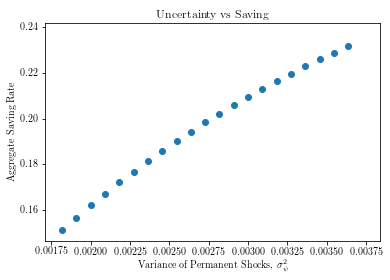

Slope=530.7061985365614, intercept=0.6766240453921681, r_value=0.9969394089293704, p_value=1.6852816164419637e-22, std=9.547588506159919


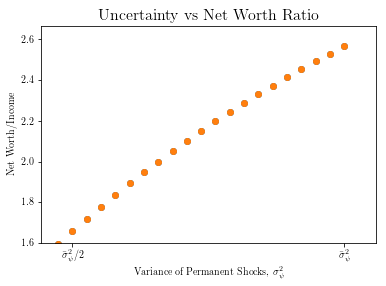

In [14]:
# Plot pVar vs saving measures
plotReg(pVarList,savRteList,
        xMin=pVarList[1]-0.0002,xMax=pVarList[-1]+0.0002,yMin=savRteList[1]-0.01,yMax=savRteList[-1]+0.01,
        xLbl=r'Variance of Permanent Shocks, $\sigma^{2}_{\psi}$',
        yLbl='Aggregate Saving Rate',
        Title='Uncertainty vs Saving',
        fileName='savRtevsPermShkVar'
       )
plt.show(block=False)
plotReg(pVarList,KtoYList,
        xMin=pVarList[1]-0.0002,xMax=pVarList[-1]+0.0002,yMin=1.7,yMax=KtoYList[-1]+0.1,
        xLbl=r'Variance of Permanent Shocks, $\sigma^{2}_{\psi}$',
        yLbl='Net Worth/Income',
        Title='Uncertainty vs Net Worth Ratio',
        fileName='BvsPermShkVar'
       )
plt.ylabel('Net Worth/Income')
plt.xlabel(r'Variance of Permanent Shocks, $\sigma^{2}_{\psi}$')
plt.title('Uncertainty vs Net Worth Ratio',fontsize=16)
plt.xlim(pVarList[1]-0.0002,pVarList[-1]+0.0002)
plt.ylim(1.6,KtoYList[-1]+0.1)
plt.scatter(pVarList,KtoYList)
plt.xticks([pVarList[1],pVarList[-1]],[r'$\bar{\sigma}^{2}_{\psi}/2$',r'$\bar{\sigma}^{2}_{\psi}$'])
fileName='BvsPermShkVar'
if Generator:
        plt.savefig(FigDir + nb_name + '-' + fileName + '.png')
        plt.savefig(FigDir + nb_name + '-' + fileName + '.svg')
        plt.savefig(FigDir + nb_name + '-' + fileName + '.pdf')
plt.show(block=False)                

In [15]:
# Calculate variance of transitory shock vs saving measures
# Restore benchmark solution
EstimationEconomy.distributeParams( # Construct consumer types whose heterogeneity is in the given parameter
    'DiscFac',
    Params.pref_type_count,# How many different types of consumer are there 
    center_estimate,       # Increase patience slightly vs cstwMPC so that maximum saving rate is higher
    spread_estimate,       # How much difference is there across consumers
    Params.dist_type)      # Default is for a uniform distribution
EstimationEconomy.solve()

savRteList_Tran = []
KtoYList_Tran   = []
tVarList   = []
tVarBase = BaselineType.TranShkStd[0] ** 2
for tVar in points * tVarBase:
    tVarList.append(tVar) # Variance is std squared
    savRteList_Tran.append(calcSavRte(EstimationEconomy,"TranShkStd",[tVar ** 0.5]))
    KtoYList_Tran.append(0.25*np.mean(np.array(EstimationEconomy.KtoYnow_hist)[EstimationEconomy.ignore_periods:]))

Slope=0.04425458972691994, intercept=0.22993889217509514, r_value=0.9997560905067558, p_value=6.235938075080433e-33, std=0.00022427988559214007


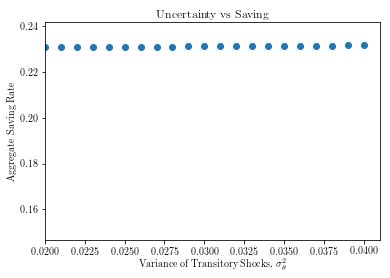

Slope=0.24992735556376564, intercept=2.554920083325562, r_value=0.9999887157190909, p_value=1.3035255504050127e-45, std=0.0002723909104974136


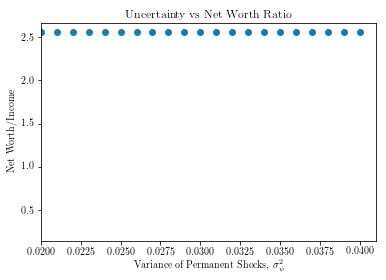

In [16]:
# Plot transitory variance versus saving measures
plotReg(tVarList,savRteList_Tran,
        xMin=tVarList[1]-0.001,xMax=tVarList[-1]+0.001,yMin=savRteList[1]-0.01,yMax=savRteList[-1]+0.01,
        xLbl=r'Variance of Transitory Shocks, $\sigma^{2}_{\theta}$',
        yLbl='Aggregate Saving Rate',
        Title='Uncertainty vs Saving',
        fileName='savRteVSTranShkVar'
       )
plt.show(block=False)
plotReg(tVarList,KtoYList_Tran,
        xMin=tVarList[1]-0.001,xMax=tVarList[-1]+0.001,yMin=savRteList[1]-0.01,yMax=KtoYList[-1]+0.1,
        xLbl=r'Variance of Permanent Shocks, $\sigma^{2}_{\psi}$',
        yLbl='Net Worth/Income',
        Title='Uncertainty vs Net Worth Ratio',
        fileName='BvsTranShkVar'
       )
plt.show(block=False)                